# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [1]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob

In [2]:
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
def split_train_test(lendata, percentage=0.8):
    return np.array_split(np.random.permutation(lendata), [round(percentage * lendata)])

LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA, 0.8)

# Implement the dataset class
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True):
        # path_to_images: where you put the fish dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # transform_extra: extra data transform
        # img_size: resize all images to a standard size
        # train: return training set or test set
        
        # Load all the images and their labels
        
        # Resize all images to a standard size and 
        tfs = [transforms.Resize((img_size, img_size)), transforms.ToTensor()]
        
        if transform_extra is not None:
            tfs.insert(0, transform_extra)
        
        transform = transforms.Compose(tfs)
        
        images = []
        labels = []

        for class_name, label in Multiclass_labels_correspondances.items():
            files = glob.glob(f"{path_to_images}/{class_name}/*.png")
            print("Class name: " + class_name)
            for file in files:
                image = Image.open(file)
                tensor = transform(image)
                images.append(tensor)
                labels.append(label)
                image.close()
            
        # Extract the images and labels with the specified file indexes      
        indicies = idxs_train if train else idxs_test
        self.images = [images[i] for i in indicies]
        self.labels = [labels[i] for i in indicies]
             
    def __len__(self):
        # Return the number of samples
        #### ADD YOUR CODE HERE ####
        return len(self.images)
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the image and its label
        #### ADD YOUR CODE HERE ####
        return self.images[idx], self.labels[idx]

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

Class name: Black Sea Sprat
Class name: Gilt-Head Bream
Class name: Shrimp
Class name: Striped Red Mullet
Class name: Trout
[(0, 811), (1, 809), (2, 787), (3, 796), (4, 797)]


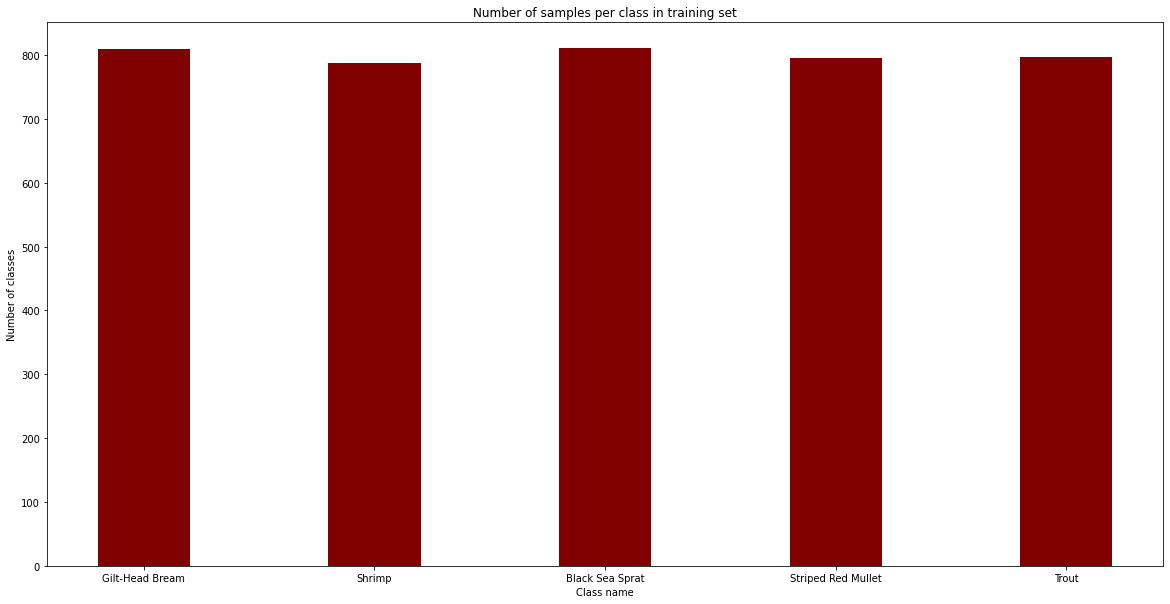

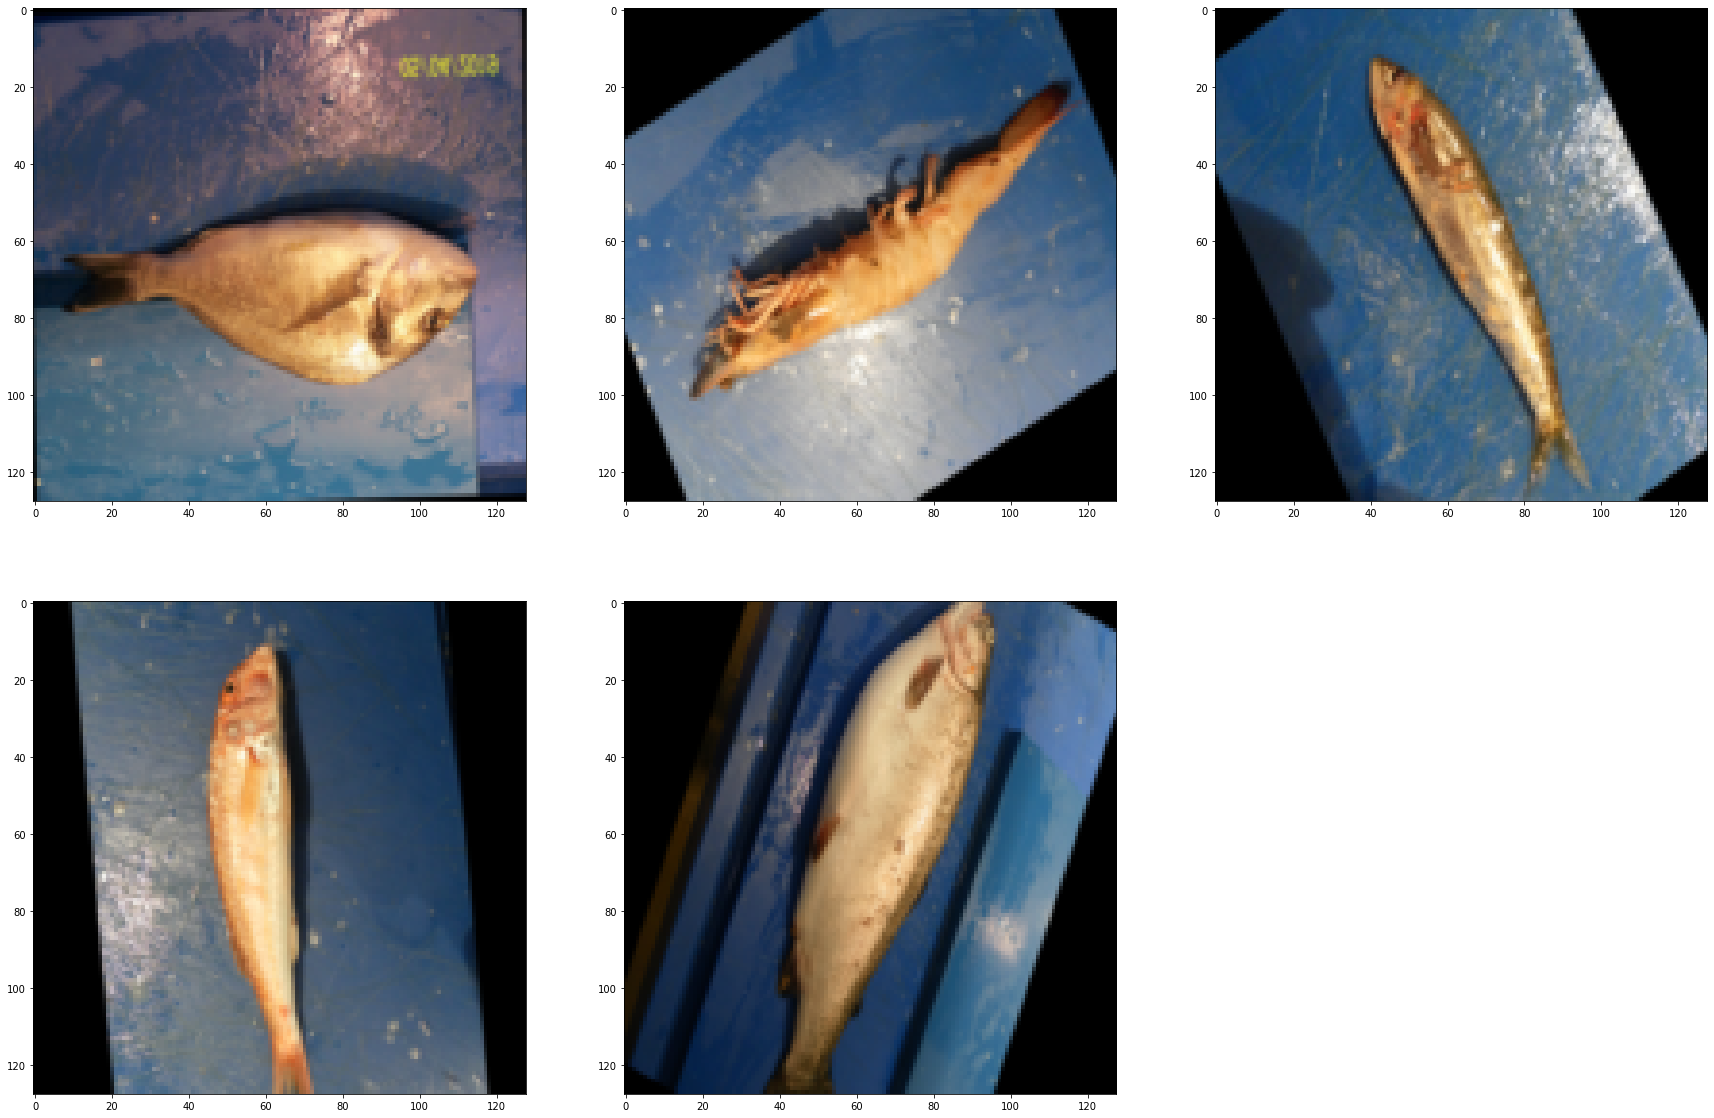

In [3]:
# Training set
img_path = './fish-dataset'
dataset  = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)

# Plot the number of samples per class
sample_map = {}
first_of_each = []
for idx, label in enumerate(dataset.labels):
    if label in sample_map:
        sample_map[label] += 1 # Add to count
    else:
        first_of_each.append(idx) # New class
        sample_map[label] = 1

inverted_labels_correspondances = dict(zip(
    Multiclass_labels_correspondances.values(), Multiclass_labels_correspondances.keys()))
        
print(sorted(sample_map.items())) # Sanity check
classes = list([inverted_labels_correspondances[i] for i in sample_map.keys()])
count = list(sample_map.values())
  
fig = plt.figure(figsize = (20, 10))
 
plt.bar(classes, count, color ='maroon', width = 0.4)
 
plt.xlabel("Class name")
plt.ylabel("Number of classes")
plt.title("Number of samples per class in training set")
plt.show()
        
# Plot 1 sample from each of the five classes in the training set
fig = plt.figure(figsize=(30, 20))
rows = 2
columns = 3
for i, idx in enumerate(first_of_each):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(dataset.images[idx].permute(1, 2, 0).numpy())
plt.show()

### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

* Can you think of 3 ways to make the dataset balanced if it is not?

* Is the dataset already pre-processed? If yes, how?

Yes, we can see that the training dataset is roughly balanced. This is because the original dataset we start off with is perfectly balanced (it contains exactly 1000 of each type of fish), but when we randomly sample our training and test datasets, we may get a slightly higher or lower portion of the different types of fish in each set. However, since the psuedorandom generator used is good, the distribution of different classes in the training and test sets is almost balanced. For example, on one occasion the distribution looked like this: 
{0: 811, 1: 809, 2: 787, 3: 796, 4: 797}. 

If the dataset were not balanced, we could (1) upsample the minority class(es), (2) downsample the majority class(es), or (3) normalise our results (or possibly different combinations of these three).

Yes, {mention rotation, all images same size (?), other transformations applied, etc.}.

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [4]:
class Net(nn.Module):
    def __init__(self, output_dims = 1):
        super(Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(3, 30, kernel_size=(5, 5), stride=1, padding=1),
            nn.BatchNorm2d(30),                         # Batch Normalisation 
            nn.ReLU(inplace=True),                      # ReLU
            nn.MaxPool2d(kernel_size=(2, 2), stride=2), # MaxPool
            # Conv layer 2
            nn.Conv2d(30, 40, kernel_size=(5, 5), stride=1, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # Conv layer 3
            nn.Conv2d(40, 50, kernel_size=(5, 5), stride=1, padding=1),
            nn.BatchNorm2d(50),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # Conv layer 4
            nn.Conv2d(50, 60, kernel_size=(5, 5), stride=1, padding=1),
            nn.BatchNorm2d(60),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        )

        self.linear_layers = nn.Sequential(
            # Fully connected layer 1
            nn.Linear(2160, 800),
            nn.ReLU(),
            # FCL 2
            nn.Linear(800, 200),
            nn.ReLU(),
            # FCL 3
            nn.Linear(200, 80),
            nn.ReLU(),
            # FCL 4 (output layer)
            nn.Linear(80, len(Multiclass_labels_correspondances)),
            # No need to apply Softmax - this is handled by nn.CrossEntropyLoss.
        )
        
    def forward(self, x):
        # Forward propagation
        x = self.cnn_layers(x)    # Conv layers
        x = x.view(x.size(0), -1) # Flatten
        x = self.linear_layers(x) # Fully connected layers
        return x

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cuda'

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [5]:
# Network - send to GPU
model = Net().to(device)

# Loss function 
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
# These are the optimal values for learning rate and weight decay based on a simple
# hyper parameter grid search.
lr = 0.003
wd = 0.001 # Weight decay to implement L2 regularisation
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Number of iterations for training
epochs = 20 # Beyond 20 epochs accuracy stagnated or even decreased

# Training batch size
train_batch_size = 200 

# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)
test_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)
test_dataloader = DataLoader(test_dataset)

Class name: Black Sea Sprat
Class name: Gilt-Head Bream
Class name: Shrimp
Class name: Striped Red Mullet
Class name: Trout
Class name: Black Sea Sprat
Class name: Gilt-Head Bream
Class name: Shrimp
Class name: Striped Red Mullet
Class name: Trout


### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [6]:
# Training
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []

    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        imgs, labs = imgs.to(device), labs.to(device)
        optimiser.zero_grad()
        prediction = model(imgs)
        loss = criterion(prediction, labs)
        loss.retain_grad()
        loss.backward()
        optimiser.step()        
        loss_curve.append(loss.item())
    print(f'--- Iteration {epoch + 1}: training loss = {np.array(loss_curve).mean()} ---')

  5%|█████▌                                                                                                        | 1/20 [00:04<01:28,  4.66s/it]

--- Iteration 1: training loss = 1.1411949217319488 ---


 10%|███████████                                                                                                   | 2/20 [00:09<01:23,  4.63s/it]

--- Iteration 2: training loss = 0.43372834771871566 ---


 15%|████████████████▌                                                                                             | 3/20 [00:13<01:18,  4.62s/it]

--- Iteration 3: training loss = 0.18424011208117008 ---


 20%|██████████████████████                                                                                        | 4/20 [00:18<01:14,  4.63s/it]

--- Iteration 4: training loss = 0.09518349543213844 ---


 25%|███████████████████████████▌                                                                                  | 5/20 [00:23<01:09,  4.63s/it]

--- Iteration 5: training loss = 0.044117672834545374 ---


 30%|█████████████████████████████████                                                                             | 6/20 [00:27<01:04,  4.63s/it]

--- Iteration 6: training loss = 0.03836266975849867 ---


 35%|██████████████████████████████████████▌                                                                       | 7/20 [00:32<01:00,  4.64s/it]

--- Iteration 7: training loss = 0.043092998676002026 ---


 40%|████████████████████████████████████████████                                                                  | 8/20 [00:37<00:55,  4.64s/it]

--- Iteration 8: training loss = 0.24029615074396132 ---


 45%|█████████████████████████████████████████████████▌                                                            | 9/20 [00:41<00:51,  4.64s/it]

--- Iteration 9: training loss = 0.07908909544348716 ---


 50%|██████████████████████████████████████████████████████▌                                                      | 10/20 [00:46<00:46,  4.64s/it]

--- Iteration 10: training loss = 0.03550288372207433 ---


 55%|███████████████████████████████████████████████████████████▉                                                 | 11/20 [00:51<00:41,  4.65s/it]

--- Iteration 11: training loss = 0.02653343612328172 ---


 60%|█████████████████████████████████████████████████████████████████▍                                           | 12/20 [00:55<00:37,  4.65s/it]

--- Iteration 12: training loss = 0.021151617541909216 ---


 65%|██████████████████████████████████████████████████████████████████████▊                                      | 13/20 [01:00<00:32,  4.65s/it]

--- Iteration 13: training loss = 0.0086528399027884 ---


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 14/20 [01:05<00:27,  4.66s/it]

--- Iteration 14: training loss = 0.00397514910728205 ---


 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 15/20 [01:09<00:23,  4.66s/it]

--- Iteration 15: training loss = 0.0027725983294658364 ---


 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 16/20 [01:14<00:18,  4.66s/it]

--- Iteration 16: training loss = 0.0016614454856608064 ---


 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 17/20 [01:19<00:13,  4.66s/it]

--- Iteration 17: training loss = 0.0014770530280657113 ---


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 18/20 [01:23<00:09,  4.66s/it]

--- Iteration 18: training loss = 0.0016830654931254685 ---


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 19/20 [01:28<00:04,  4.66s/it]

--- Iteration 19: training loss = 0.0016478678735438734 ---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:32<00:00,  4.65s/it]

--- Iteration 20: training loss = 0.001569601648952812 ---


### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [7]:
# Deploy the model
with torch.no_grad():
    model.eval()
    predicted_labels, true_labels = zip(*[(model.forward(x.to(device)), y.to(device).item()) for x, y in test_dataloader])

### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

In [8]:
correct = 0
for pred, gold in zip(predicted_labels, true_labels):
    if pred.argmax() == gold:
        correct += 1
        
print("Accuracy: " + str(correct / len(true_labels)))

Accuracy: 0.992


## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [9]:
Multiclass_labels_correspondances = {
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

LENDATA = 3999 # Removed corrupted image
idxs_train,idxs_test = split_train_test(LENDATA, 0.8)

# Dataloaders
train_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)
test_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)
test_dataloader = DataLoader(test_dataset)

Class name: Hourse Mackerel
Class name: Red Mullet
Class name: Red Sea Bream
Class name: Sea Bass
Class name: Hourse Mackerel
Class name: Red Mullet
Class name: Red Sea Bream
Class name: Sea Bass


### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [10]:
def freeze_till_last(model):
    for param in model.cnn_layers:
        param.requires_grad = False

freeze_till_last(model)
# Modify the last layer. This layer is not freezed.
# for layer in model.linear_layers:
#     layer.requires_grad = True

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.04
wd = 0.008 # Weight decay to implement L2 regularisation
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Number of iterations for training
epochs = 20

# Training batch size
train_batch_size = 200

### Step 4.3: Train and test your finetuned model. (5 points)

In [11]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []

    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        imgs, labs = imgs.to(device), labs.to(device)
        optimiser.zero_grad()
        prediction = model(imgs)
        loss = criterion(prediction, labs)
#         loss.requires_grad = True
        loss.retain_grad()
        loss.backward()
        optimiser.step()        
        loss_curve.append(loss.item())
    print(f'--- Iteration {epoch + 1}: training loss = {np.array(loss_curve).mean()} ---')
    
# Deploy the model on the test set
with torch.no_grad():
    model.eval()
    predicted_labels, true_labels = zip(*[(model.forward(x.to(device)), y.to(device).item()) for x, y in test_dataloader])

# Evaluate the performance
correct = 0
for pred, gold in zip(predicted_labels, true_labels):
    if pred.argmax() == gold:
        correct += 1
        
print("Accuracy: " + str(correct / len(true_labels)))

  5%|█████▌                                                                                                        | 1/20 [00:03<01:11,  3.76s/it]

--- Iteration 1: training loss = 26.390221945941448 ---


 10%|███████████                                                                                                   | 2/20 [00:07<01:07,  3.72s/it]

--- Iteration 2: training loss = 1.7107818126678467 ---


 15%|████████████████▌                                                                                             | 3/20 [00:11<01:03,  3.71s/it]

--- Iteration 3: training loss = 1.4089974239468575 ---


 20%|██████████████████████                                                                                        | 4/20 [00:14<00:59,  3.71s/it]

--- Iteration 4: training loss = 1.3107112720608711 ---


 25%|███████████████████████████▌                                                                                  | 5/20 [00:18<00:55,  3.71s/it]

--- Iteration 5: training loss = 1.1989171504974365 ---


 30%|█████████████████████████████████                                                                             | 6/20 [00:22<00:51,  3.71s/it]

--- Iteration 6: training loss = 0.9563043676316738 ---


 35%|██████████████████████████████████████▌                                                                       | 7/20 [00:26<00:48,  3.73s/it]

--- Iteration 7: training loss = 0.7203694730997086 ---


 40%|████████████████████████████████████████████                                                                  | 8/20 [00:29<00:44,  3.73s/it]

--- Iteration 8: training loss = 0.7815440744161606 ---


 45%|█████████████████████████████████████████████████▌                                                            | 9/20 [00:33<00:40,  3.72s/it]

--- Iteration 9: training loss = 0.5782167911529541 ---


 50%|██████████████████████████████████████████████████████▌                                                      | 10/20 [00:37<00:37,  3.72s/it]

--- Iteration 10: training loss = 1.0253268145024776 ---


 55%|███████████████████████████████████████████████████████████▉                                                 | 11/20 [00:40<00:33,  3.72s/it]

--- Iteration 11: training loss = 0.6271973662078381 ---


 60%|█████████████████████████████████████████████████████████████████▍                                           | 12/20 [00:44<00:29,  3.71s/it]

--- Iteration 12: training loss = 0.5272592399269342 ---


 65%|██████████████████████████████████████████████████████████████████████▊                                      | 13/20 [00:48<00:25,  3.71s/it]

--- Iteration 13: training loss = 0.4700859095901251 ---


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 14/20 [00:52<00:22,  3.71s/it]

--- Iteration 14: training loss = 0.5060676727443933 ---


 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 15/20 [00:55<00:18,  3.72s/it]

--- Iteration 15: training loss = 0.4495759401470423 ---


 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 16/20 [00:59<00:14,  3.72s/it]

--- Iteration 16: training loss = 0.3620000444352627 ---


 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 17/20 [01:03<00:11,  3.72s/it]

--- Iteration 17: training loss = 0.3295063190162182 ---


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 18/20 [01:06<00:07,  3.72s/it]

--- Iteration 18: training loss = 0.3005284061655402 ---


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 19/20 [01:10<00:03,  3.72s/it]

--- Iteration 19: training loss = 0.46642126329243183 ---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.72s/it]

--- Iteration 20: training loss = 0.31432157568633556 ---


Accuracy: 0.56


### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

#### ADD YOUR RESPONSE HERE ####